In [1]:
'''FOR COLAB'''
# !pip install cmake
# !pip install dlib
# !pip install face_recognition
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive/', force_remount=True)

# import os
# os.chdir(os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'DeepFake Detector'))
# print(f'current cwd = {os.getcwd()}')

'FOR COLAB'

In [2]:
'''IMPORTS'''
import os
import cv2
import PIL
import face_recognition
import numpy as np
from PIL import Image
from operator import itemgetter
from heapq import nsmallest
from math import ceil
from IPython.display import display
import ipyplot
%matplotlib inline

In [3]:
'''EXTARCT EVERY FRAME (OVER INTERVAL) FROM VIDEO'''
def get_every_frame(video , interval=1):
    frames = []
    vidcap = cv2.VideoCapture(video)
    success, image = vidcap.read()

    count = 0
    while success:
        if not count % interval:
            frames.append(image[:, :, ::-1])
        success, image = vidcap.read()
        count += 1
        
    return frames

In [4]:
'''FIND ALL FACES'''
def get_face_locations(frames):
    face_coordinates = []
    for frame in frames:
        coordinates_found = face_recognition.face_locations(frame)
        if coordinates_found is not None and len(coordinates_found):
            face_coordinates.append(coordinates_found[-1])
        else:
            face_coordinates.append(None)
    return face_coordinates

In [5]:
'''FIND CENTROID OF FACE LOCATIONS'''
def centroid(face_coordinates):
    cleaned_face_coordinates = np.asarray([f for f in face_coordinates if f is not None])

    length = cleaned_face_coordinates.shape[0]
    sum_t = np.sum(cleaned_face_coordinates[:, 0])
    sum_r = np.sum(cleaned_face_coordinates[:, 1])
    sum_b = np.sum(cleaned_face_coordinates[:, 2])
    sum_l = np.sum(cleaned_face_coordinates[:, 3])

    return np.asarray((sum_t, sum_r, sum_b, sum_l)) / length

In [6]:

def distance_from_centroid(centroid, face_coordinates):
    dist_from_centroid = []
    for coord in face_coordinates:
        if coord is not None:
            dist_from_centroid.append(np.linalg.norm(centroid-coord))
        else:
            dist_from_centroid.append(coord)
            
    return dist_from_centroid

In [7]:
def get_stable_faces(movement_thershold, dist_from_centroid, zoomed=False):
    stable_faces = []
    if zoomed:
        for dist, coord, frame in zip(dist_from_centroid, face_coordinates, frames):
            if dist is not None:
                if dist <= movement_thershold:
                    t,r,b,l = coord
                    stable_faces.append(frame[t:b, l:r])
    else:
        face_coordinates_in_thrshld = []
        for dist, coord in zip(dist_from_centroid, face_coordinates):
            if dist is not None and dist <= movement_thershold:
                face_coordinates_in_thrshld.append(coord)

        face_coordinates_in_thrshld = [f for f in face_coordinates_in_thrshld if f is not None]
        min_top = min(face_coordinates_in_thrshld, key=itemgetter(0))[0]
        max_right = max(face_coordinates_in_thrshld, key=itemgetter(1))[1]
        max_bottom = max(face_coordinates_in_thrshld, key=itemgetter(2))[2]
        min_left = min(face_coordinates_in_thrshld, key=itemgetter(3))[3]

        for dist, frame in zip(dist_from_centroid, frames):
            if dist is not None and dist <= movement_thershold:
                stable_faces.append(frame[min_top:max_bottom, min_left:max_right])
                
    return stable_faces

In [8]:
def average(frames):
    h,w,c = frames[0].shape
    N = len(frames)
    avg = np.zeros((h,w,c), np.float)

    for frame in frames:
        frame = np.array(frame, dtype=np.float)
        avg += (frame/N)
    avg = np.array(np.round(avg), dtype=np.uint8)

    return avg

In [9]:
def difference(frames, interval):
    h,w,c = frames[0].shape
    diff = np.zeros((h,w,c), np.float)

    for current_frame, next_frame in zip(frames[::interval], frames[interval::interval]):
        current_frame = np.array(current_frame, dtype=np.float)
        next_frame = np.array(next_frame, dtype=np.float)
        diff += np.absolute(next_frame - current_frame)
    diff = np.array(np.round(diff), dtype=np.uint8)

    return diff

In [19]:
video_dir_path = os.path.join('.', 'Celeb-DF-v2', 'Celeb-real')
# video_dir_path = os.path.join('.', 'Celeb-DF-v2', 'Celeb-synthesis')
video_listdir = os.listdir(video_dir_path)

# video = os.path.join(video_dir_path, 'id1_0007.mp4') #best case
# video = os.path.join(video_dir_path, video_listdir[17]) #avg case real
# video = os.path.join(video_dir_path, 'id10_id12_0007.mp4') #avg case fake
video = os.path.join(video_dir_path, 'id34_0007.mp4') #hard
# video = os.path.join(video_dir_path, 'id44_0005.mp4') #movement

In [20]:
frames = get_every_frame(video, interval=1)
face_coordinates = get_face_locations(frames)
# centroid = centroid(face_coordinates)

TypeError: 'numpy.ndarray' object is not callable


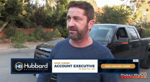
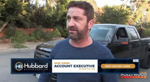
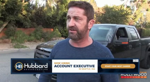
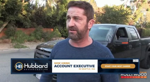
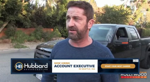
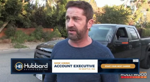
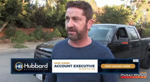
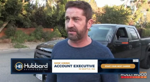
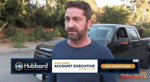
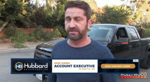


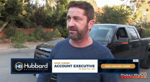
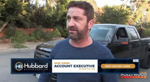
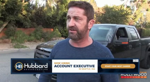
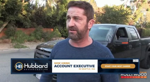
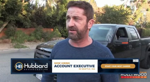
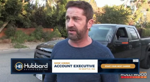
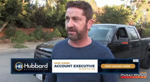
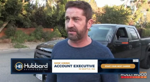
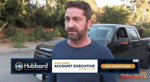
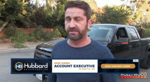

In [21]:
# show frames
ipyplot.plot_images(list(map(Image.fromarray, frames[-10:])))

In [28]:
dist_from_centroid = distance_from_centroid(centroid, face_coordinates)
movement_thershold = nsmallest(15, set(filter(bool, dist_from_centroid)))[-1]
stable_faces = get_stable_faces(movement_thershold, dist_from_centroid, zoomed=False)


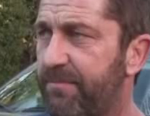
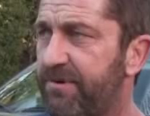
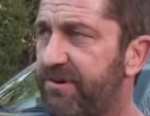
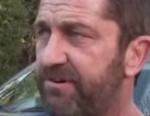
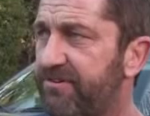
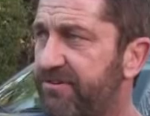
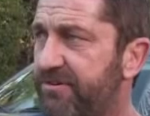
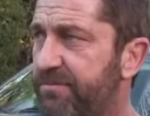
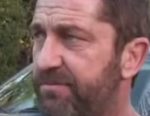
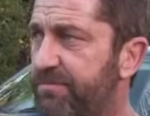


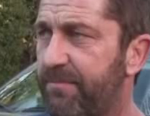
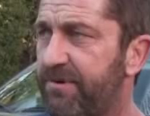
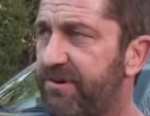
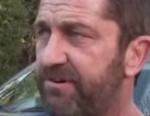
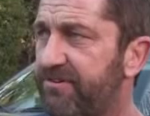
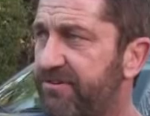
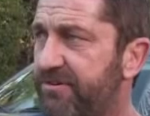
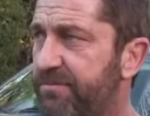
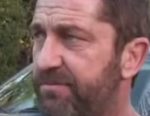
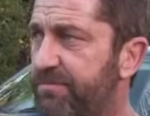

In [29]:
# show stable frames
ipyplot.plot_images(list(map(Image.fromarray, stable_faces[-10:])))


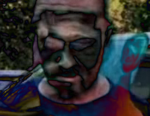
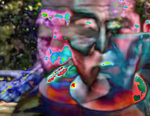
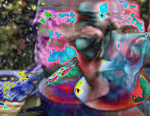
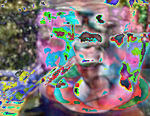
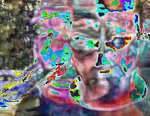
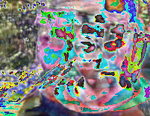
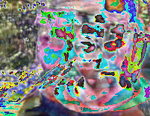
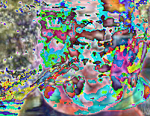
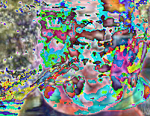
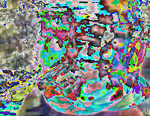
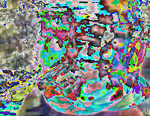
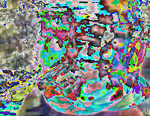
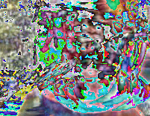
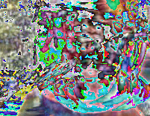
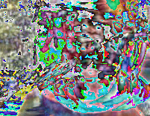
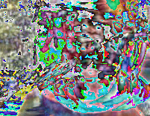
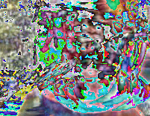
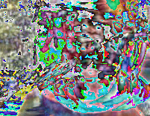
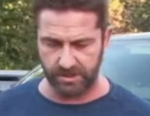
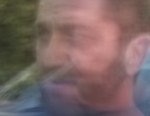


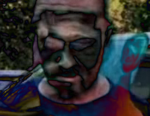
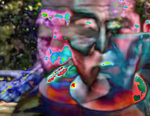
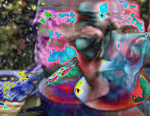
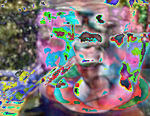
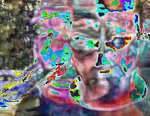
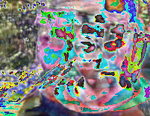
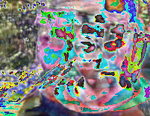
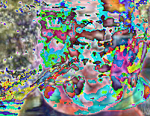
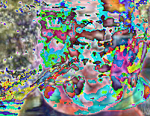
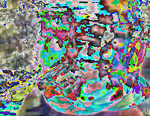
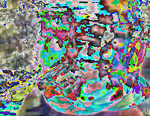
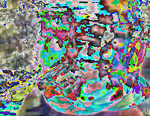
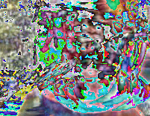
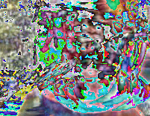
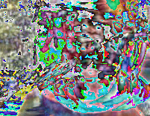
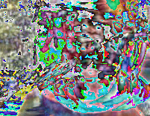
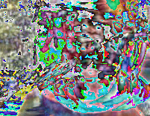
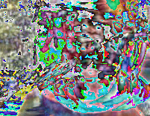
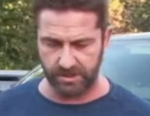
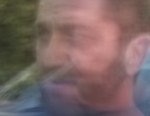

In [31]:
# show diffs over interval + face + avg
diff_array = [difference(stable_faces, interval=ceil(len(stable_faces)/i)) for i in range(2,20,1)]
all_images = diff_array+[stable_faces[0],average(stable_faces)]
ipyplot.plot_images(list(map(Image.fromarray, all_images)))